In [1]:
import trimesh

scene = trimesh.Scene()

In [ ]:
import torch
import numpy as np
import os
import shutil
from tqdm import tqdm
import yaml

import sys
import os

# models
from my_code.models.diag_conditional import DiagConditionedUnet
from diffusers import DDPMScheduler

import my_code.datasets.template_dataset as template_dataset

import my_code.diffusion_training_sign_corr.data_loading as data_loading

import networks.diffusion_network as diffusion_network
import matplotlib.pyplot as plt
import my_code.utils.plotting_utils as plotting_utils
import utils.fmap_util as fmap_util
import metrics.geodist_metric as geodist_metric
from my_code.sign_canonicalization.training import predict_sign_change
import argparse
from pyFM_fork.pyFM.refine.zoomout import zoomout_refine
import my_code.utils.zoomout_custom as zoomout_custom
from utils.shape_util import compute_geodesic_distmat
from my_code.diffusion_training_sign_corr.test.test_diffusion_cond import select_p2p_map_dirichlet, log_to_database, parse_args
import accelerate
import my_code.sign_canonicalization.test_sign_correction as test_sign_correction
import networks.fmap_network as fmap_network

tqdm._instances.clear()


In [3]:

class RegularizedFMNet(torch.nn.Module):
    """Compute the functional map matrix representation in DPFM"""
    def __init__(self, lmbda=0.01, resolvant_gamma=0.5, bidirectional=False):
        super(RegularizedFMNet, self).__init__()
        self.lmbda = lmbda
        self.resolvant_gamma = resolvant_gamma
        self.bidirectional = bidirectional

    def compute_functional_map(self, A, B, evals_x, evals_y):
        # A = torch.bmm(evecs_trans_x, feat_x)  # [B, K, C]
        # B = torch.bmm(evecs_trans_y, feat_y)  # [B, K, C]

        D = fmap_network.get_mask(evals_x, evals_y, self.resolvant_gamma)  # [B, K, K]

        A_t = A.transpose(1, 2)  # [B, C, K]
        A_A_t = torch.bmm(A, A_t)  # [B, K, K]
        B_A_t = torch.bmm(B, A_t)  # [B, K, K]

        C_i = []
        for i in range(evals_x.shape[1]):
            D_i = torch.cat([torch.diag(D[bs, i, :].flatten()).unsqueeze(0) for bs in range(evals_x.shape[0])], dim=0)
            C = torch.bmm(torch.inverse(A_A_t + self.lmbda * D_i), B_A_t[:, [i], :].transpose(1, 2))
            C_i.append(C.transpose(1, 2))

        Cxy = torch.cat(C_i, dim=1)
         
        return Cxy
    



def get_geo_error(
    p2p_first, p2p_second,
    evecs_first, evecs_second,
    corr_first, corr_second,
    num_evecs, apply_zoomout,
    dist_x,
    regularized=False,
    evecs_trans_first=None, evecs_trans_second=None,
    evals_first=None, evals_second=None,
    return_p2p=False, return_Cxy=False,
    A2=None, fmnet=None
    ):
        
    if regularized:
        Cxy = fmnet.compute_functional_map(
            evecs_trans_second[:num_evecs, p2p_second].unsqueeze(0),
            evecs_trans_first[:num_evecs, p2p_first].unsqueeze(0),
            evals_second[:num_evecs].unsqueeze(0),
            evals_first[:num_evecs].unsqueeze(0), 
        )[0].T
        
    else:
        Cxy = torch.linalg.lstsq(
            evecs_second[:, :num_evecs][p2p_second],
            evecs_first[:, :num_evecs][p2p_first]
            ).solution
    
    
    if apply_zoomout:
        Cxy = zoomout_custom.zoomout(
            FM_12=Cxy, 
            evects1=evecs_first,
            evects2=evecs_second,
            nit=evecs_first.shape[1] - num_evecs, step=1,
            A2=A2
        )
        num_evecs = evecs_first.shape[1]
        
    p2p = fmap_util.fmap2pointmap(
        C12=Cxy,
        evecs_x=evecs_first[:, :num_evecs],
        evecs_y=evecs_second[:, :num_evecs],
        ).cpu()
    
    geo_err = geodist_metric.calculate_geodesic_error(
        dist_x, corr_first.cpu(), corr_second.cpu(), p2p, return_mean=True
    )
    
    # if return_p2p:
    #     return geo_err * 100, p2p
    # else:
    #     return geo_err * 100
    
    if not return_p2p and not return_Cxy:
        return geo_err * 100
    
    payload = [geo_err * 100]
    
    if return_p2p:
        payload.append(p2p)
    if return_Cxy:
        payload.append(Cxy)
        
    return payload



In [4]:
def filter_p2p_by_confidence(
        p2p_first, p2p_second,
        confidence_scores_first, confidence_scores_second,
        confidence_threshold, log_file_name
    ):
    
    assert p2p_first.shape[0] == p2p_second.shape[0]
    
    # select points with both confidence scores above threshold
    valid_points = (confidence_scores_first < confidence_threshold) & (confidence_scores_second < confidence_threshold)
    
    with open(log_file_name, 'a') as f:
        
        while valid_points.sum() < 0.05 * len(valid_points):
            confidence_threshold += 0.05
            valid_points = (confidence_scores_first < confidence_threshold) & (confidence_scores_second < confidence_threshold)
            
            print(f'Increasing confidence threshold: {confidence_threshold}')
        print(f'Valid points: {valid_points.sum()}')
        assert valid_points.sum() > 0, "No valid points found"
        
    p2p_first = p2p_first[valid_points]
    p2p_second = p2p_second[valid_points]
    
    return p2p_first, p2p_second


def get_fmaps_evec_signs(
        data_range, single_dataset, model,
        noise_scheduler, config, args,
        template_shape, sign_corr_net
    ):
        
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    num_evecs = config["model_params"]["sample_size"]
    
    
    C_yx_est_full_list = []
    evecs_first_signs_full_list = []
    evecs_second_signs_full_list = []


    for i in tqdm(data_range, desc='Calculating fmaps to template, evec signs'):

        data = single_dataset[i]
        
        verts_first = template_shape['verts'].unsqueeze(0).to(device)
        verts_second = data['verts'].unsqueeze(0).to(device)
        
        faces_first = template_shape['faces'].unsqueeze(0).to(device)
        faces_second = data['faces'].unsqueeze(0).to(device)

        evecs_first = template_shape['evecs'][:, :num_evecs].unsqueeze(0).to(device)
        evecs_second = data['evecs'][:, :num_evecs].unsqueeze(0).to(device)
        

        if config["sign_net"]["with_mass"]:
            mass_mat_first = torch.diag_embed(
                template_shape['mass'].unsqueeze(0)
                ).to(device)
            mass_mat_second = torch.diag_embed(
                data['mass'].unsqueeze(0)
                ).to(device)
        else:
            mass_mat_first = None
            mass_mat_second = None


        ###############################################
        # get conditioning and signs num_iters_avg times
        ###############################################

        evecs_cond_first_list = []
        evecs_cond_second_list = []
        evecs_first_signs_list = []
        evecs_second_signs_list = []

        for _ in range(args.num_iters_avg):

            # predict the sign change
            with torch.no_grad():
                sign_pred_first, support_vector_norm_first, _ = predict_sign_change(
                    sign_corr_net, verts_first, faces_first, evecs_first, 
                    mass_mat=mass_mat_first, input_type=sign_corr_net.input_type,
                    evecs_per_support=config["sign_net"]["evecs_per_support"],
                    
                    mass=template_shape['mass'].unsqueeze(0), L=template_shape['L'].unsqueeze(0),
                    evals=template_shape['evals'][:config["sign_net"]["net_params"]["k_eig"]].unsqueeze(0),
                    evecs=template_shape['evecs'][:,:config["sign_net"]["net_params"]["k_eig"]].unsqueeze(0),
                    gradX=template_shape['gradX'].unsqueeze(0), gradY=template_shape['gradY'].unsqueeze(0)
                    )
                sign_pred_second, support_vector_norm_second, _ = predict_sign_change(
                    sign_corr_net, verts_second, faces_second, evecs_second, 
                    mass_mat=mass_mat_second, input_type=sign_corr_net.input_type,
                    evecs_per_support=config["sign_net"]["evecs_per_support"],
                    
                    mass=data['mass'].unsqueeze(0), L=data['L'].unsqueeze(0),
                    evals=data['evals'][:config["sign_net"]["net_params"]["k_eig"]].unsqueeze(0),
                    evecs=data['evecs'][:,:config["sign_net"]["net_params"]["k_eig"]].unsqueeze(0),
                    gradX=data['gradX'].unsqueeze(0), gradY=data['gradY'].unsqueeze(0)
                    )

            # correct the evecs
            evecs_first_corrected = evecs_first.cpu()[0] * torch.sign(sign_pred_first).cpu()
            evecs_first_corrected_norm = evecs_first_corrected / torch.norm(evecs_first_corrected, dim=0, keepdim=True)
            
            evecs_second_corrected = evecs_second.cpu()[0] * torch.sign(sign_pred_second).cpu()
            evecs_second_corrected_norm = evecs_second_corrected / torch.norm(evecs_second_corrected, dim=0, keepdim=True)
            

            # product with support
            if config["sign_net"]["with_mass"]:
            # if config["sign_net"]['cond_mass_normalize']:
                
                mass_mat_first = torch.diag_embed(
                    template_shape['mass'].unsqueeze(0)
                    ).to(device)
                mass_mat_second = torch.diag_embed(
                    data['mass'].unsqueeze(0)
                    ).to(device)
                
                evecs_cond_first = torch.nn.functional.normalize(
                    support_vector_norm_first[0].cpu().transpose(0, 1) \
                        @ mass_mat_first[0].cpu(),
                    p=2, dim=1) \
                        @ evecs_first_corrected_norm
                
                evecs_cond_second = torch.nn.functional.normalize(
                    support_vector_norm_second[0].cpu().transpose(0, 1) \
                        @ mass_mat_second[0].cpu(),
                    p=2, dim=1) \
                        @ evecs_second_corrected_norm 
                
            else:
                evecs_cond_first = support_vector_norm_first[0].cpu().transpose(0, 1) @ evecs_first_corrected_norm
                evecs_cond_second = support_vector_norm_second[0].cpu().transpose(0, 1) @ evecs_second_corrected_norm
                
            evecs_cond_first_list.append(evecs_cond_first)
            evecs_cond_second_list.append(evecs_cond_second)
            evecs_first_signs_list.append(torch.sign(sign_pred_first).cpu())
            evecs_second_signs_list.append(torch.sign(sign_pred_second).cpu())
            
        evecs_cond_first_list = torch.stack(evecs_cond_first_list)
        evecs_cond_second_list = torch.stack(evecs_cond_second_list)
        evecs_first_signs_list = torch.stack(evecs_first_signs_list)
        evecs_second_signs_list = torch.stack(evecs_second_signs_list)    
        
        
        ###############################################
        # Conditioning
        ###############################################

        conditioning = torch.cat(
            (evecs_cond_first_list.unsqueeze(1), evecs_cond_second_list.unsqueeze(1)),
            1)
        
        ###############################################
        # Sample the model
        ###############################################
        
        x_sampled = torch.rand(args.num_iters_avg, 1, 
                            config["model_params"]["sample_size"],
                            config["model_params"]["sample_size"]).to(device)
        y = conditioning.to(device)    
         
        # Sampling loop
        for t in noise_scheduler.timesteps:

            # Get model pred
            with torch.no_grad():
                residual = model(x_sampled, t,
                                    conditioning=y
                                    ).sample

            # Update sample with step
            x_sampled = noise_scheduler.step(residual, t, x_sampled).prev_sample
            
        ###############################################
        # Save the fmaps and signs of evecs
        ###############################################
        
        C_yx_est_full_list.append(x_sampled.cpu())
        evecs_first_signs_full_list.append(evecs_first_signs_list)
        evecs_second_signs_full_list.append(evecs_second_signs_list)
        
        
    return C_yx_est_full_list, evecs_first_signs_full_list, evecs_second_signs_full_list


def get_evec_signs_from_remeshed(
            data_range, single_dataset, single_dataset_remeshed,
            evecs_second_signs_full_list_remeshed,
            num_evecs
        ):
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    for curr_iter, i in enumerate(tqdm(data_range, desc='Getting evec signs from remeshed')):
        
        data_orig = single_dataset[i]
        evecs_second_orig = data_orig['evecs'][:, :num_evecs].to(device)
        
        data_remeshed = single_dataset_remeshed[i]
        evecs_second_remeshed = data_remeshed['evecs'][:, :num_evecs].to(device)
        corr_orig_to_remeshed = data_remeshed['corr_orig_to_remeshed'].to(device)
        
        
        prod_evecs_orig_remesh_corrected = evecs_second_orig.transpose(0, 1) @ evecs_second_remeshed[corr_orig_to_remeshed]

        sign_difference = torch.sign(torch.diagonal(prod_evecs_orig_remesh_corrected, dim1=0, dim2=1)).cpu()
        evecs_second_signs_full_list_remeshed[curr_iter] = evecs_second_signs_full_list_remeshed[curr_iter] * sign_difference
        
    return evecs_second_signs_full_list_remeshed
            

def get_p2p_maps_template(
        data_range, single_dataset,
        C_yx_est_full_list, evecs_first_signs_full_list, evecs_second_signs_full_list,
        template_shape, args, log_file_name, config
    ):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    num_evecs = config["model_params"]["sample_size"]

    for curr_iter, i in enumerate(tqdm(data_range, desc='Calculating p2p maps to template')):
        
        data = single_dataset[i]
        
        verts_second = data['verts']
        faces_second = data['faces']
        
        evecs_first = template_shape['evecs'][:, :num_evecs]
        evecs_second = data['evecs'][:, :num_evecs]
        
        C_yx_est_i = C_yx_est_full_list[curr_iter]
        evecs_first_signs_i = evecs_first_signs_full_list[curr_iter]
        evecs_second_signs_i = evecs_second_signs_full_list[curr_iter]
        
        
        ##########################################################
        # Convert fmaps to p2p maps to template
        ##########################################################
        
        single_dataset.additional_data[i]['p2p_est'] = []
        single_dataset.additional_data[i]['Cyx_template'] = []
        
        for k in range(args.num_iters_avg):
    
            evecs_first_corrected = evecs_first * evecs_first_signs_i[k]
            evecs_second_corrected = evecs_second * evecs_second_signs_i[k]
            Cyx_est_k = C_yx_est_i[k][0].cpu()

            p2p_est_k = fmap_util.fmap2pointmap(
                C12=Cyx_est_k.to(device),
                evecs_x=evecs_second_corrected.to(device),
                evecs_y=evecs_first_corrected.to(device),
                ).cpu()

            single_dataset.additional_data[i]['p2p_est'].append(p2p_est_k)
            single_dataset.additional_data[i]['Cyx_template'].append(Cyx_est_k)
    
        single_dataset.additional_data[i]['p2p_est'] = torch.stack(single_dataset.additional_data[i]['p2p_est'])
        single_dataset.additional_data[i]['Cyx_template'] = torch.stack(single_dataset.additional_data[i]['Cyx_template'])
            
        ##########################################################
        # p2p map selection
        ##########################################################
        
        dist_second = torch.tensor(
            compute_geodesic_distmat(
                verts_second.numpy(),
                faces_second.numpy())    
        )
        
        p2p_dirichlet, p2p_median, confidence_scores, dirichlet_energy_list = select_p2p_map_dirichlet(
            single_dataset.additional_data[i]['p2p_est'],
            verts_second,
            template_shape['L'], 
            dist_second,
            num_samples_median=args.num_samples_median
            )
        
        single_dataset.additional_data[i]['p2p_dirichlet'] = p2p_dirichlet
        single_dataset.additional_data[i]['p2p_median'] = p2p_median
        single_dataset.additional_data[i]['confidence_scores_median'] = confidence_scores
        
        single_dataset.additional_data[i]['geo_dist'] = dist_second
        
        
        with open(log_file_name, 'a') as f:
            print(f'Template stage, {i}')
            print(f'Dirichlet energy: {dirichlet_energy_list}')
            print(f'Confidence scores: {confidence_scores}')
            print(f'Mean confidence score: {confidence_scores.mean():.3f}')
            print(f'Median confidence score: {confidence_scores.median():.3f}')
            print('')
            
    return single_dataset



In [5]:

def get_pairwise_error(
    data_range_pair, test_dataset, num_evecs, args, log_file_name, fmnet
):
       
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
       
    geo_errs_gt = []
    geo_errs_pairzo = []
    geo_errs_dirichlet = []
    geo_errs_median = []
    geo_errs_median_filtered = []
    geo_errs_median_filtered_noZo = []
    geo_errs_dirichlet_pairzo = []
    geo_errs_median_pairzo = []
    

    for i in tqdm(data_range_pair, desc='Calculating pair fmaps'):
        
        data = test_dataset[i]        
        
        evecs_first = data['first']['evecs'][:, :].to(device)
        evecs_second = data['second']['evecs'][:, :].to(device)
        
        evecs_trans_first = data['first']['evecs_trans'][:, :].to(device)
        evecs_trans_second = data['second']['evecs_trans'][:, :].to(device)
        
        evals_first = data['first']['evals'][:num_evecs].to(device)
        evals_second = data['second']['evals'][:num_evecs].to(device)

        corr_first = data['first']['corr'].to(device)
        corr_second = data['second']['corr'].to(device)
        
        mass_second = data['second']['mass'].to(device)
        
        ###############################################
        # Functional maps
        ###############################################
                
        p2p_est_first = data['first']['p2p_est'].to(device)
        p2p_est_second = data['second']['p2p_est'].to(device)
        
        p2p_dirichlet_first = data['first']['p2p_dirichlet'].to(device)
        p2p_dirichlet_second = data['second']['p2p_dirichlet'].to(device)
        
        p2p_median_first = data['first']['p2p_median'].to(device)
        p2p_median_second = data['second']['p2p_median'].to(device)
        
        # dist_x = torch.tensor(
        #     compute_geodesic_distmat(data['first']['verts'].numpy(), data['first']['faces'].numpy())    
        # )
        dist_x = data['first']['geo_dist']
        
        ###############################################
        # Geodesic errors
        ###############################################
        
        # GT geo error
        geo_err_gt = get_geo_error(
            corr_first, corr_second,
            evecs_first, evecs_second,
            corr_first, corr_second,
            num_evecs, False,
            dist_x, A2=mass_second,
            )
        
        # mean pred geo error with zoomout
        geo_err_est_pairzo = []
        p2p_est_pairzo = []
        for k in range(args.num_iters_avg):
            geo_err_k, p2p_k = get_geo_error(
                p2p_est_first[k], p2p_est_second[k],
                evecs_first, evecs_second,
                corr_first, corr_second,
                num_evecs, True,
                dist_x, A2=mass_second,
                return_p2p=True
                )
            geo_err_est_pairzo.append(geo_err_k)
            p2p_est_pairzo.append(p2p_k)
            
        geo_err_est_pairzo = torch.tensor(geo_err_est_pairzo)
        p2p_est_pairzo = torch.stack(p2p_est_pairzo)
        
        # dirichlet geo error
        geo_err_est_dirichlet = get_geo_error(
            p2p_dirichlet_first, p2p_dirichlet_second,
            evecs_first, evecs_second,
            corr_first, corr_second,
            num_evecs, True,
            dist_x, A2=mass_second,
            )
         
        # median geo error
        geo_err_est_median = get_geo_error(
            p2p_median_first, p2p_median_second,
            evecs_first, evecs_second,
            corr_first, corr_second,
            num_evecs, True,
            dist_x, A2=mass_second,
            )
        
        # median geo error with confidence filtering
        p2p_median_first_filtered, p2p_median_second_filtered = filter_p2p_by_confidence(
            p2p_median_first, p2p_median_second,
            data['first']['confidence_scores_median'], data['second']['confidence_scores_median'],
            args.confidence_threshold, log_file_name
            )
        geo_err_est_median_filtered = get_geo_error(
            p2p_median_first_filtered, p2p_median_second_filtered,
            evecs_first, evecs_second,
            corr_first, corr_second,
            num_evecs, True,
            dist_x, A2=mass_second,
            regularized=True,
            evecs_trans_first=evecs_trans_first, 
            evecs_trans_second=evecs_trans_second, 
            evals_first=evals_first, 
            evals_second=evals_second,
            fmnet=fmnet
            )
        geo_err_est_median_filtered_noZo = get_geo_error(
            p2p_median_first_filtered, p2p_median_second_filtered,
            evecs_first, evecs_second,
            corr_first, corr_second,
            num_evecs, False,
            dist_x, A2=mass_second,
            regularized=True,
            evecs_trans_first=evecs_trans_first, 
            evecs_trans_second=evecs_trans_second, 
            evals_first=evals_first, 
            evals_second=evals_second,
            fmnet=fmnet
            )
        
        ###############################################
        # Dirichlet and median maps at the pairwise stage
        ###############################################

        p2p_dirichlet_pairzo, p2p_median_pairzo, confidence_scores, dirichlet_energy_list = select_p2p_map_dirichlet(
            p2p_est_pairzo,
            data['first']['verts'],
            data['second']['L'], 
            dist_x,
            num_samples_median=args.num_samples_median
            )
        
        geo_err_dirichlet_pairzo = geodist_metric.calculate_geodesic_error(
            dist_x, corr_first.cpu(), corr_second.cpu(), p2p_dirichlet_pairzo, return_mean=True
        ) * 100
        geo_err_median_pairzo = geodist_metric.calculate_geodesic_error(
            dist_x, corr_first.cpu(), corr_second.cpu(), p2p_median_pairzo, return_mean=True
        ) * 100
        
        
        ###############################################
        # Logging
        ###############################################

        # replace code above with writing to log file
        with open(log_file_name, 'a') as f:
            print(f'{i}: {data["first"]["id"]}, {data["second"]["id"]}')
            print(f'Geo error GT: {geo_err_gt:.2f}')
            print(f'Geo error est pairzo: {geo_err_est_pairzo}')
            print(f'Geo error est pairzo mean: {geo_err_est_pairzo.mean():.2f}')
            print(f'Geo error est dirichlet: {geo_err_est_dirichlet:.2f}')
            print(f'Geo error est median: {geo_err_est_median:.2f}')
            print(f'Geo error est median filtered: {geo_err_est_median_filtered:.2f}')
            print(f'Geo error est median filtered noZo: {geo_err_est_median_filtered_noZo:.2f}')
            print(f'Geo error dirichlet pairzo: {geo_err_dirichlet_pairzo:.2f}')
            print(f'Geo error median pairzo: {geo_err_median_pairzo:.2f}')
            print('-----------------------------------')
        
        geo_errs_gt.append(geo_err_gt)
        geo_errs_pairzo.append(geo_err_est_pairzo.mean())
        geo_errs_dirichlet.append(geo_err_est_dirichlet)
        geo_errs_median.append(geo_err_est_median)
        geo_errs_median_filtered.append(geo_err_est_median_filtered)
        geo_errs_median_filtered_noZo.append(geo_err_est_median_filtered_noZo)
        geo_errs_dirichlet_pairzo.append(geo_err_dirichlet_pairzo)
        geo_errs_median_pairzo.append(geo_err_median_pairzo)


    geo_errs_gt = torch.tensor(geo_errs_gt)
    geo_errs_pairzo = torch.tensor(geo_errs_pairzo)
    geo_errs_dirichlet = torch.tensor(geo_errs_dirichlet)
    geo_errs_median = torch.tensor(geo_errs_median)
    geo_errs_median_filtered = torch.tensor(geo_errs_median_filtered)
    geo_errs_median_filtered_noZo = torch.tensor(geo_errs_median_filtered_noZo)
    geo_errs_dirichlet_pairzo = torch.tensor(geo_errs_dirichlet_pairzo)
    geo_errs_median_pairzo = torch.tensor(geo_errs_median_pairzo)
        
    # replace code above with writing to log file
    with open(log_file_name, 'a') as f:
        print('-----------------------------------')
        print('Total statistics')
        print('-----------------------------------')
        print(f'GT geo err mean: {geo_errs_gt.mean():.2f}')
        print('')
        print(f'Pairzoomout geo err mean: {geo_errs_pairzo.mean():.2f}')
        print(f'Pairzoomout geo err median: {geo_errs_pairzo.median():.2f}')
        print(f'Pairzoomout geo err min: {geo_errs_pairzo.min():.2f}')
        print(f'Pairzoomout geo err max: {geo_errs_pairzo.max():.2f}')      
        print('')
        print(f'Dirichlet geo err mean: {geo_errs_dirichlet.mean():.2f}')
        print(f'Dirichlet geo err median: {geo_errs_dirichlet.median():.2f}')
        print(f'Dirichlet geo err min: {geo_errs_dirichlet.min():.2f}')
        print(f'Dirichlet geo err max: {geo_errs_dirichlet.max():.2f}')
        print('')
        print(f'Median geo err mean: {geo_errs_median.mean():.2f}')
        print(f'Median geo err median: {geo_errs_median.median():.2f}')
        print(f'Median geo err min: {geo_errs_median.min():.2f}')
        print(f'Median geo err max: {geo_errs_median.max():.2f}')
        print('')
        print(f'Median geo err filtered mean: {geo_errs_median_filtered.mean():.2f}')
        print(f'Median geo err filtered median: {geo_errs_median_filtered.median():.2f}')
        print(f'Median geo err filtered min: {geo_errs_median_filtered.min():.2f}')
        print(f'Median geo err filtered max: {geo_errs_median_filtered.max():.2f}')
        print('')
        print(f'Median geo err filtered noZo mean: {geo_errs_median_filtered_noZo.mean():.2f}')
        print(f'Median geo err filtered noZo median: {geo_errs_median_filtered_noZo.median():.2f}')
        print('')
        print(f'Dirichlet pairzoomout geo err mean: {geo_errs_dirichlet_pairzo.mean():.2f}')
        print(f'Dirichlet pairzoomout geo err median: {geo_errs_dirichlet_pairzo.median():.2f}')
        print('')
        print(f'Median pairzoomout geo err mean: {geo_errs_median_pairzo.mean():.2f}')
        print(f'Median pairzoomout geo err median: {geo_errs_median_pairzo.median():.2f}')
        print('-----------------------------------')

    data_to_log = {
        'experiment_name': args.experiment_name,
        'checkpoint_name': args.checkpoint_name, 
        'smoothing': f'{args.smoothing_type}-{args.smoothing_iter}' if args.smoothing_type is not None else 'no_smoothing',
        'dataset_name': args.dataset_name,
        'split': args.split,
        
        'confidence_filtered': geo_errs_median_filtered.mean().item(),
        
        'dirichlet': geo_errs_dirichlet.mean().item(),
        'p2p_median': geo_errs_median.mean().item(),
        
        'zoomout_mean': geo_errs_pairzo.mean().item(),
        'zoomout_median': geo_errs_pairzo.median().item(),
        
        'filtered_noZo': geo_errs_median_filtered_noZo.mean().item(),
        'dirichlet_pairzo': geo_errs_dirichlet_pairzo.mean().item(),
        'median_pairzo': geo_errs_median_pairzo.mean().item(),
        }
    
    return data_to_log



In [15]:
class Arguments:
    def __init__(self):
        self.experiment_name='single_64_2-2ev_64-128-128_remeshed_fixed'
        self.checkpoint_name='epoch_99'
        
        self.dataset_name='DT4D_inter_pair'
        self.split='test'
        
        self.num_iters_avg=100
        self.num_samples_median=8
        self.confidence_threshold=0.3
        
        self.smoothing_type='taubin'
        self.smoothing_iter=5
        
        # self.smoothing_type=None
        # self.smoothing_iter=None

In [16]:
args = Arguments()

# configuration
experiment_name = args.experiment_name
checkpoint_name = args.checkpoint_name

### config
exp_base_folder = f'/home/s94zalek_hpc/shape_matching/my_code/experiments/ddpm/{experiment_name}'
with open(f'{exp_base_folder}/config.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)


### model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = DiagConditionedUnet(config["model_params"])

if "accelerate" in config and config["accelerate"]:
    accelerate.load_checkpoint_in_model(model, f"{exp_base_folder}/checkpoints/{checkpoint_name}/model.safetensors")
else:
    model.load_state_dict(torch.load(f"{exp_base_folder}/checkpoints/{checkpoint_name}"))

model.to(device)

### Sign correction network
sign_corr_net = diffusion_network.DiffusionNet(
    **config["sign_net"]["net_params"]
    )        
sign_corr_net.load_state_dict(torch.load(
        f'{config["sign_net"]["net_path"]}/{config["sign_net"]["n_iter"]}.pth'
        ))
sign_corr_net.to(device)


### noise scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2',
                                clip_sample=True) 

# fmap network
fmnet = RegularizedFMNet(lmbda=0.01, resolvant_gamma=0.5)


### test dataset
dataset_name = args.dataset_name
split = args.split

single_dataset, test_dataset = data_loading.get_val_dataset(
    dataset_name, split, 200, preload=False, return_evecs=True
    )
sign_corr_net.cache_dir = single_dataset.lb_cache_dir

num_evecs = config["model_params"]["sample_size"]

##########################################
# Template
##########################################

template_shape = template_dataset.get_template(
    num_evecs=single_dataset.num_evecs,
    centering='bbox',
    template_path=f'/home/s94zalek_hpc/shape_matching/data/SURREAL_full/template/{config["sign_net"]["template_type"]}/template.off',
    template_corr=np.loadtxt(
        f'/home/s94zalek_hpc/shape_matching/data/SURREAL_full/template/{config["sign_net"]["template_type"]}/corr.txt',
        dtype=np.int32) - 1
    )    

##########################################
# Logging
##########################################

if args.smoothing_type is not None:
    test_name = f'{args.smoothing_type}-{args.smoothing_iter}'
else:
    test_name = 'no_smoothing'

log_dir = f'{exp_base_folder}/eval/{checkpoint_name}/{dataset_name}-{split}/{test_name}'
os.makedirs(log_dir, exist_ok=True)

fig_dir = f'{log_dir}/figs'
os.makedirs(fig_dir, exist_ok=True)

log_file_name = f'{log_dir}/log_{test_name}.txt'


In [ ]:


##########################################
# 1.1: Template stage, get the functional maps and signs of evecs
##########################################

# data_range_1 = range(len(single_dataset))

# data_range_1 = range(2)

data_range_1 = [0, 61]
# print('!!! WARNING: only 2 samples are processed !!!')



if args.smoothing_type is not None:
    
    # Optionally smooth the dataset
    single_dataset_remeshed = test_sign_correction.remesh_dataset(
        dataset=single_dataset, 
        name=dataset_name,
        remesh_targetlen=1,
        smoothing_type=args.smoothing_type,
        smoothing_iter=args.smoothing_iter,
        num_evecs=200,
    )
    C_yx_est_full_list, evecs_first_signs_full_list, evecs_second_signs_full_list_remeshed = get_fmaps_evec_signs(
        data_range_1, single_dataset_remeshed, model,
        noise_scheduler, config, args,
        template_shape, sign_corr_net
    )  
    evecs_second_signs_full_list = get_evec_signs_from_remeshed(
        data_range_1, single_dataset, single_dataset_remeshed,
        evecs_second_signs_full_list_remeshed,
        num_evecs
    )
    
else:
    C_yx_est_full_list, evecs_first_signs_full_list, evecs_second_signs_full_list = get_fmaps_evec_signs(
        data_range_1, single_dataset, model,
        noise_scheduler, config, args,
        template_shape, sign_corr_net
    )
    

In [ ]:
##########################################
# 1.2: Template stage, get p2p maps for the original dataset
##########################################
        
# single_dataset = get_p2p_maps_template(
#     data_range_1, single_dataset,
#     C_yx_est_full_list, evecs_first_signs_full_list, evecs_second_signs_full_list,
#     template_shape, args, log_file_name, config
#     )   

from my_code.utils.median_p2p_map import get_median_p2p_map, dirichlet_energy


device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_evecs = config["model_params"]["sample_size"]

for curr_iter, i in enumerate(tqdm(data_range_1, desc='Calculating p2p maps to template')):
    
    # if i != 65:
    #     continue
    
    data = single_dataset[i]
    
    verts_second = data['verts']
    faces_second = data['faces']
    
    evecs_first = template_shape['evecs'][:, :num_evecs]
    evecs_second = data['evecs'][:, :num_evecs]
    
    evecs_first_full = template_shape['evecs']
    evecs_second_full = data['evecs']
    
    
    C_yx_est_i = C_yx_est_full_list[curr_iter]
    evecs_first_signs_i = evecs_first_signs_full_list[curr_iter]
    evecs_second_signs_i = evecs_second_signs_full_list[curr_iter]
    
    if 'geo_dist' not in data:
        dist_second = torch.tensor(
            compute_geodesic_distmat(
                verts_second.numpy(),
                faces_second.numpy())    
        )
    else:
        dist_second = data['geo_dist']
    
    
    ##########################################################
    # Convert fmaps to p2p maps to template
    ##########################################################
    
    single_dataset.additional_data[i]['p2p_est'] = []
    single_dataset.additional_data[i]['Cyx_template'] = []
    
    for k in range(args.num_iters_avg):
        
        fmap_dimension_k = num_evecs
        
        energy_condition = False
        
        while not energy_condition:

            evecs_first_corrected = evecs_first[:,:fmap_dimension_k] * evecs_first_signs_i[k][:,:fmap_dimension_k]
            evecs_second_corrected = evecs_second[:,:fmap_dimension_k] * evecs_second_signs_i[k][:,:fmap_dimension_k]
            Cyx_est_k = C_yx_est_i[k][0][:fmap_dimension_k,:fmap_dimension_k].cpu()

            p2p_est_k = fmap_util.fmap2pointmap(
                C12=Cyx_est_k.to(device),
                evecs_x=evecs_second_corrected.to(device),
                evecs_y=evecs_first_corrected.to(device),
                ).cpu()

            dirichlet_energy_k = dirichlet_energy(p2p_est_k, verts_second, template_shape['L'])
        
            energy_condition = dirichlet_energy_k < 30 or fmap_dimension_k <= 8
            if not energy_condition:
                fmap_dimension_k -= 2
                
                print(f'Dirichlet energy: {dirichlet_energy_k}, Decreasing fmap dimension to: {fmap_dimension_k}')
            else:
                print(f'Condition satisfied, Dirichlet energy: {dirichlet_energy_k}, Fmap dimension: {fmap_dimension_k}')
                
                zo_num_evecs = 200
                
                if fmap_dimension_k < zo_num_evecs:
                    
                    evecs_first_zo = torch.cat(
                        [evecs_first_corrected, evecs_first_full[:, fmap_dimension_k:zo_num_evecs]],
                        dim=1
                    ).to(device)
                    
                    evecs_second_zo = torch.cat(
                        [evecs_second_corrected, evecs_second_full[:, fmap_dimension_k:zo_num_evecs]],
                        dim=1                    
                    ).to(device)
                    
                    
                    Cyx_zo_k = zoomout_custom.zoomout(
                        FM_12=Cyx_est_k.to(device), 
                        evects1=evecs_second_zo,
                        evects2=evecs_first_zo,
                        nit=zo_num_evecs-fmap_dimension_k, step=1,
                        A2=template_shape['mass'].to(device),
                    )
                    p2p_zo_k = fmap_util.fmap2pointmap(
                        C12=Cyx_zo_k,
                        evecs_x=evecs_second_zo,
                        evecs_y=evecs_first_zo,
                        ).cpu()
                    
                    dirichlet_energy_zo = dirichlet_energy(p2p_zo_k, verts_second, template_shape['L'])
                    
                    print(f'Zoomout energy: {dirichlet_energy_zo}')
                    
                    p2p_est_k = p2p_zo_k

        
        single_dataset.additional_data[i]['p2p_est'].append(p2p_est_k)
        single_dataset.additional_data[i]['Cyx_template'].append(Cyx_est_k)
        


    single_dataset.additional_data[i]['p2p_est'] = torch.stack(single_dataset.additional_data[i]['p2p_est'])
    # single_dataset.additional_data[i]['Cyx_template'] = torch.stack(single_dataset.additional_data[i]['Cyx_template'])
        
    ##########################################################
    # p2p map selection
    ##########################################################
    
    p2p_dirichlet, p2p_median, confidence_scores, dirichlet_energy_list = select_p2p_map_dirichlet(
        single_dataset.additional_data[i]['p2p_est'],
        verts_second,
        template_shape['L'], 
        dist_second,
        num_samples_median=args.num_samples_median
        )
    
    single_dataset.additional_data[i]['p2p_dirichlet'] = p2p_dirichlet
    single_dataset.additional_data[i]['p2p_median'] = p2p_median
    single_dataset.additional_data[i]['confidence_scores_median'] = confidence_scores
    
    single_dataset.additional_data[i]['geo_dist'] = dist_second
    
    
    print(f'Template stage, {i}')
    print(f'Dirichlet energy: {dirichlet_energy_list}')
    print(f'Confidence scores: {confidence_scores}')
    print(f'Mean confidence score: {confidence_scores.mean():.3f}')
    print(f'Median confidence score: {confidence_scores.median():.3f}')
    print('')
    

In [19]:
##########################################
# Pairwise stage
##########################################

# data_range_2 = range(len(test_dataset))

data_range_2 = [960]

# data_range_2 = range(2)
# print('!!! WARNING: only 2 samples are processed !!!')
    
test_dataset.dataset = single_dataset

# data_to_save = get_pairwise_error(
#     data_range_2, test_dataset, num_evecs, args, log_file_name, fmnet
# )


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


for i in tqdm(data_range_2, desc='Calculating pair fmaps'):
    
    data = test_dataset[i]        
    
    evecs_first = data['first']['evecs'][:, :].to(device)
    evecs_second = data['second']['evecs'][:, :].to(device)
    
    evecs_trans_first = data['first']['evecs_trans'][:, :].to(device)
    evecs_trans_second = data['second']['evecs_trans'][:, :].to(device)
    
    evals_first = data['first']['evals'][:num_evecs].to(device)
    evals_second = data['second']['evals'][:num_evecs].to(device)

    corr_first = data['first']['corr'].to(device)
    corr_second = data['second']['corr'].to(device)
    
    mass_second = data['second']['mass'].to(device)
    
    ###############################################
    # Functional maps
    ###############################################
            
    p2p_est_first = data['first']['p2p_est'].to(device)
    p2p_est_second = data['second']['p2p_est'].to(device)
    
    p2p_dirichlet_first = data['first']['p2p_dirichlet'].to(device)
    p2p_dirichlet_second = data['second']['p2p_dirichlet'].to(device)
    
    p2p_median_first = data['first']['p2p_median'].to(device)
    p2p_median_second = data['second']['p2p_median'].to(device)
    
    # dist_x = torch.tensor(
    #     compute_geodesic_distmat(data['first']['verts'].numpy(), data['first']['faces'].numpy())    
    # )
    dist_x = data['first']['geo_dist']
    
    ###############################################
    # Geodesic errors
    ###############################################
    
    # GT geo error
    geo_err_gt = get_geo_error(
        corr_first, corr_second,
        evecs_first, evecs_second,
        corr_first, corr_second,
        num_evecs, False,
        dist_x, A2=mass_second,
        )
    
    # mean pred geo error with zoomout
    geo_err_est_pairzo = []
    p2p_est_pairzo = []
    for k in range(args.num_iters_avg):
        geo_err_k, p2p_k = get_geo_error(
            p2p_est_first[k], p2p_est_second[k],
            evecs_first, evecs_second,
            corr_first, corr_second,
            num_evecs, True,
            dist_x, A2=mass_second,
            return_p2p=True
            )
        geo_err_est_pairzo.append(geo_err_k)
        p2p_est_pairzo.append(p2p_k)
        
    geo_err_est_pairzo = torch.tensor(geo_err_est_pairzo)
    p2p_est_pairzo = torch.stack(p2p_est_pairzo)
    
    # dirichlet geo error
    geo_err_est_dirichlet, Cxy_dirichlet = get_geo_error(
        p2p_dirichlet_first, p2p_dirichlet_second,
        evecs_first, evecs_second,
        corr_first, corr_second,
        num_evecs, True,
        dist_x, A2=mass_second,
        return_Cxy=True
        )
        
    # median geo error
    geo_err_est_median = get_geo_error(
        p2p_median_first, p2p_median_second,
        evecs_first, evecs_second,
        corr_first, corr_second,
        num_evecs, True,
        dist_x, A2=mass_second,
        )
    
    # median geo error with confidence filtering
    p2p_median_first_filtered, p2p_median_second_filtered = filter_p2p_by_confidence(
        p2p_median_first, p2p_median_second,
        data['first']['confidence_scores_median'], data['second']['confidence_scores_median'],
        args.confidence_threshold, log_file_name
        )
    geo_err_est_median_filtered, p2p_median_filtered, Cxy_median_filtered = get_geo_error(
        p2p_median_first_filtered, p2p_median_second_filtered,
        evecs_first, evecs_second,
        corr_first, corr_second,
        num_evecs, True,
        dist_x, A2=mass_second,
        regularized=True,
        evecs_trans_first=evecs_trans_first, 
        evecs_trans_second=evecs_trans_second, 
        evals_first=evals_first, 
        evals_second=evals_second,
        fmnet=fmnet, return_Cxy=True, return_p2p=True
        )
    geo_err_est_median_filtered_noZo = get_geo_error(
        p2p_median_first_filtered, p2p_median_second_filtered,
        evecs_first, evecs_second,
        corr_first, corr_second,
        num_evecs, False,
        dist_x, A2=mass_second,
        regularized=True,
        evecs_trans_first=evecs_trans_first, 
        evecs_trans_second=evecs_trans_second, 
        evals_first=evals_first, 
        evals_second=evals_second,
        fmnet=fmnet
        )
    
    ###############################################
    # Dirichlet and median maps at the pairwise stage
    ###############################################

    p2p_dirichlet_pairzo, p2p_median_pairzo, confidence_scores, dirichlet_energy_list = select_p2p_map_dirichlet(
        p2p_est_pairzo,
        data['first']['verts'],
        data['second']['L'], 
        dist_x,
        num_samples_median=args.num_samples_median
        )
    
    geo_err_dirichlet_pairzo = geodist_metric.calculate_geodesic_error(
        dist_x, corr_first.cpu(), corr_second.cpu(), p2p_dirichlet_pairzo, return_mean=True
    ) * 100
    geo_err_median_pairzo = geodist_metric.calculate_geodesic_error(
        dist_x, corr_first.cpu(), corr_second.cpu(), p2p_median_pairzo, return_mean=True
    ) * 100
    
    
    ###############################################
    # Logging
    ###############################################

    # replace code above with writing to log file
    print(f'{i}: {data["first"]["id"]}, {data["second"]["id"]}')
    print(f'Geo error GT: {geo_err_gt:.2f}')
    print(f'Geo error est pairzo: {geo_err_est_pairzo}')
    print(f'Geo error est pairzo mean: {geo_err_est_pairzo.mean():.2f}')
    print(f'Geo error est dirichlet: {geo_err_est_dirichlet:.2f}')
    print(f'Geo error est median: {geo_err_est_median:.2f}')
    print(f'Geo error est median filtered: {geo_err_est_median_filtered:.2f}')
    print(f'Geo error est median filtered noZo: {geo_err_est_median_filtered_noZo:.2f}')
    print(f'Geo error dirichlet pairzo: {geo_err_dirichlet_pairzo:.2f}')
    print(f'Geo error median pairzo: {geo_err_median_pairzo:.2f}')
    print('-----------------------------------')


# Single ZO to 200

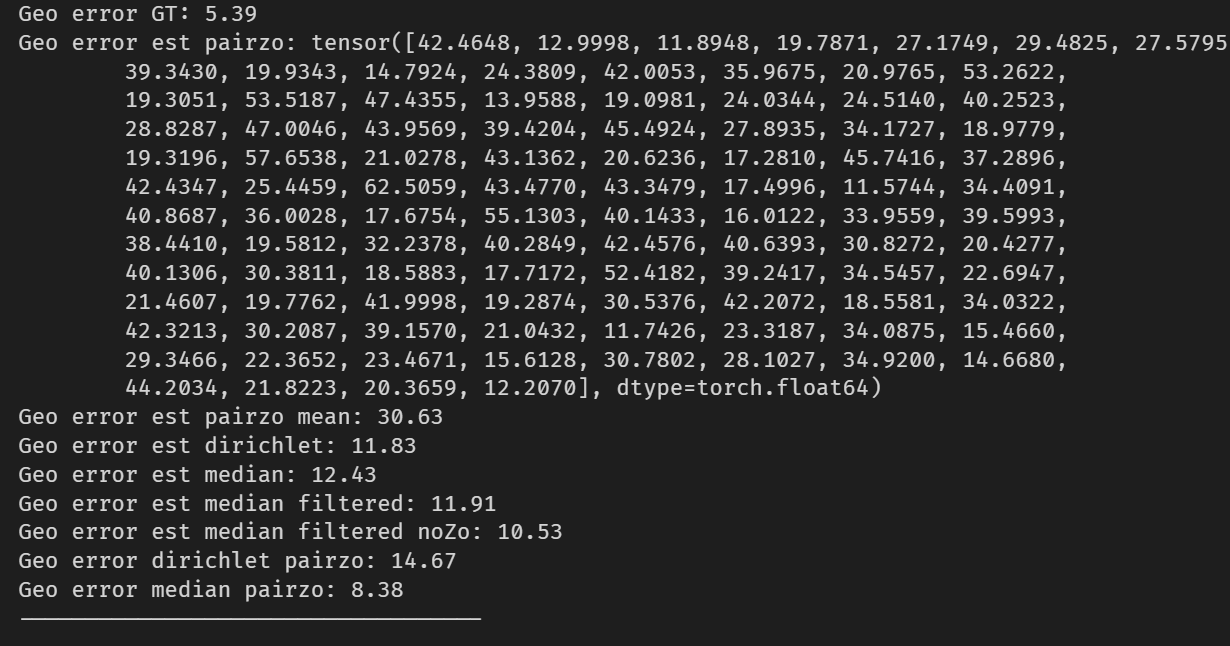

# Single ZO to 64

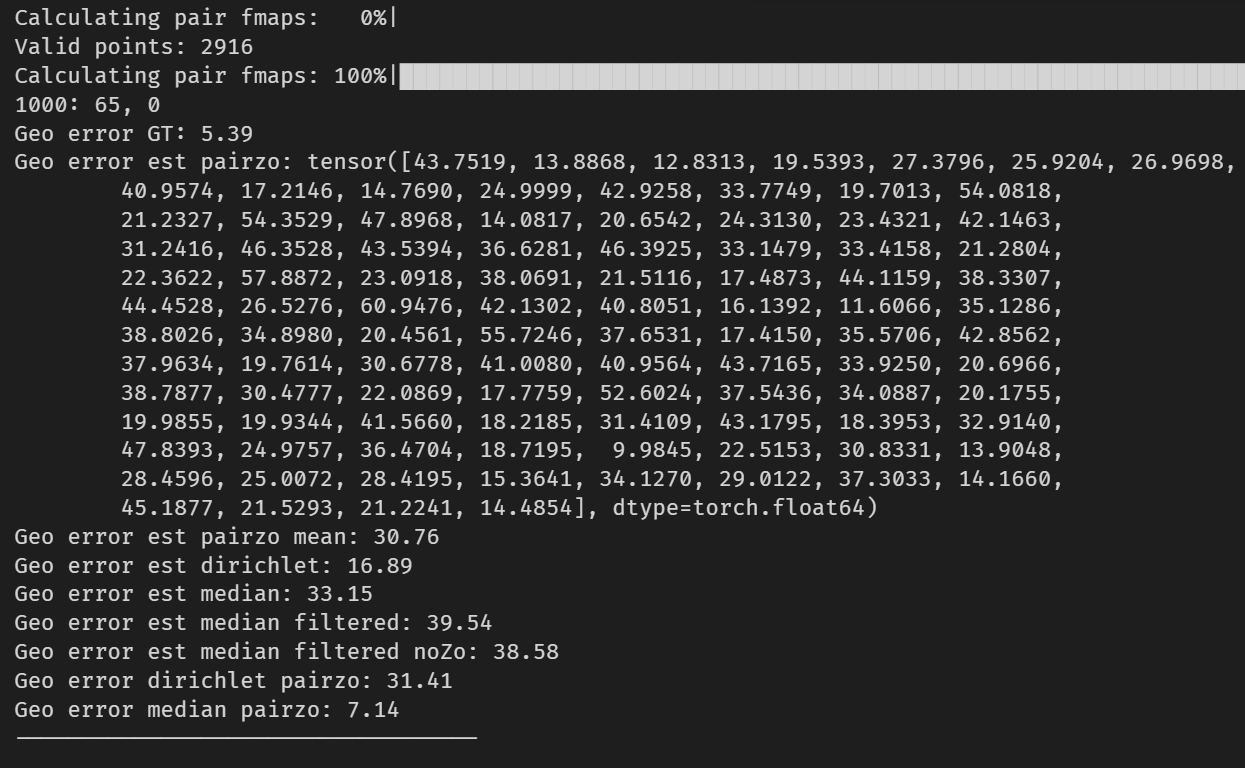

In [41]:
p2p_median_filtered.shape

In [ ]:
import my_code.utils.plotting_utils as plotting_utils

scene.geometry.clear()

plotting_utils.plot_p2p_map(
    scene,
    data['first']['verts'], data['first']['faces'],
    data['second']['verts'], data['second']['faces'],
    p2p_median_pairzo.cpu(),
    axes_color_gradient=[0, 2],
    base_cmap='hsv'
)

scene.show() 

In [ ]:
import my_code.utils.plotting_utils as plotting_utils

scene.geometry.clear()

plotting_utils.plot_p2p_map(
    scene,
    # data['first']['verts'], data['first']['faces'],
    single_dataset[65]['verts'], single_dataset[65]['faces'],
    template_shape['verts'], template_shape['faces'],
    single_dataset[65]['p2p_est'][0].cpu(),
    axes_color_gradient=[0, 2],
    base_cmap='hsv'
)

scene.show()

In [114]:
import my_code.utils.plotting_utils as plotting_utils

scene.geometry.clear()

plotting_utils.plot_p2p_map(
    scene,
    # data['first']['verts'], data['first']['faces'],
    single_dataset[0]['verts'], single_dataset[0]['faces'],
    template_shape['verts'], template_shape['faces'],
    single_dataset[0]['p2p_est'][0].cpu(),
    axes_color_gradient=[0, 2],
    base_cmap='hsv'
)

scene.show()

In [107]:
C_yx_est_full_list[0].shape

In [117]:
import my_code.utils.plotting_utils as plotting_utils
import matplotlib.pyplot as plt

l = 0
h = 64

fig, axs = plt.subplots(1, 5, figsize=(16, 4))

plotting_utils.plot_Cxy(fig, axs[0],  C_yx_est_full_list[0][1][0],
                        'fmnet', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1],  single_dataset[0]['Cyx_template'][4],
                        'fmnet', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[2],  single_dataset[0]['Cyx_template'][8],
                        'fmnet', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[3],  single_dataset[0]['Cyx_template'][15],
                        'fmnet', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[4],  Cxy_dirichlet.cpu(),
                        'evecs', l, h, show_grid=False, show_colorbar=False)
plt.show()

# Check the remeshed version

In [90]:
evecs_second_signs_full_list_remeshed[0].shape

In [27]:


Cxy_zoomout = zoomout_custom.zoomout(
    FM_12=C_yx_est_full_list[0][0][0][:8,:8].to(device), 
    evects1=(single_dataset[65]['evecs'][:, :num_evecs] * evecs_second_signs_full_list[0][0][:, :]).to(device),
    evects2=(template_shape['evecs'][:,:num_evecs] * evecs_first_signs_full_list[0][0][:, :]).to(device),
    nit=64-8, step=1,
    # A2=A2
).cpu()

In [31]:
num_evecs_reduced = 64

p2p_remeshed = fmap_util.fmap2pointmap(
    # C12=C_yx_est_full_list[0][0][0][:num_evecs_reduced,:num_evecs_reduced],
    C12=Cxy_zoomout,
    evecs_x=single_dataset[65]['evecs'][:, :num_evecs_reduced] * evecs_second_signs_full_list[0][0][:, :num_evecs_reduced].cpu(),
    evecs_y=template_shape['evecs'][:, :num_evecs_reduced] * evecs_first_signs_full_list[0][0][:, :num_evecs_reduced].cpu(),
    ).cpu()


In [ ]:
import my_code.utils.plotting_utils as plotting_utils

scene.geometry.clear()

plotting_utils.plot_p2p_map(
    scene,
    # data['first']['verts'], data['first']['faces'],
    # single_dataset_remeshed[0]['verts'], single_dataset_remeshed[0]['faces'],
    single_dataset[65]['verts'], single_dataset[65]['faces'],
    template_shape['verts'], template_shape['faces'],
    
    

    p2p_remeshed,
    # single_dataset[0]['p2p_est'][0].cpu(),
    axes_color_gradient=[0, 2],
    base_cmap='hsv'
)

scene.show()

In [98]:
single_dataset_remeshed = test_sign_correction.remesh_dataset(
    dataset=single_dataset, 
    name=dataset_name,
    remesh_targetlen=1,
    smoothing_type=args.smoothing_type,
    smoothing_iter=args.smoothing_iter,
    num_evecs=200,
)
C_yx_est_full_list, evecs_first_signs_full_list, evecs_second_signs_full_list_remeshed = get_fmaps_evec_signs(
    data_range_1, single_dataset_remeshed, model,
    noise_scheduler, config, args,
    template_shape, sign_corr_net
)

In [ ]:
# convert args to dictionary
args_dict = vars(args)
args_dict

In [ ]:
payload = {
    **vars(args),
    '1':2,
    '3':4,
}
payload